In [1]:
import os, dill, numpy as np, pandas
from matplotlib import pyplot as plt
import statsmodels.api as sm
%matplotlib inline
sens_10_path = "batch_data/sensitivity10"
sweep_path = "batch_data/sweep_analysis"
baseline_path = "batch_data/baseline.db"

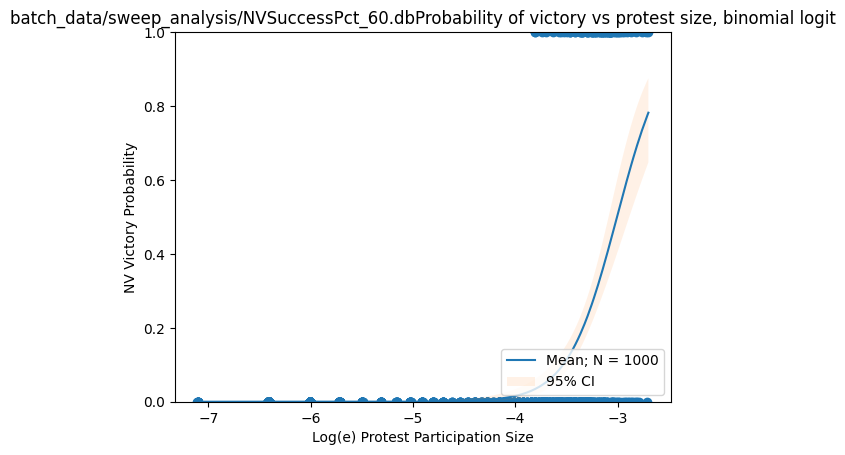

In [21]:
# plot varied sweep param (pillar pct to win)
import os, dill
foldername = sweep_path
fnames = sorted(os.listdir(foldername))
base_wins = 0
base_max = [0,0,0]
#fig = plt.figure(figsize = (12,6.5))
#ax = fig.add_axes([0,0,1,1])

pairsNV = []
quantifier = ['Max_InProtestPct', 'Max_ActualInProtestPct', 'Max_NVCitizens'][0]

baseline_path = f"{sweep_path}/{os.listdir(sweep_path)[4]}"
with open(baseline_path, 'rb') as file:
    results = dill.load(file)
    for run in results:
        pairsNV.append( (np.log(float(run[quantifier])),  int(run['victory'] == 2) )  )
            

pairsNV.sort(key = lambda x: x[0])
popsNV, successNV = [x[0] for x in pairsNV],[x[1] for x in pairsNV]
series_pctpop = pandas.Series(popsNV)
plt.scatter(popsNV, successNV)

binom_model = sm.GLM(successNV,  sm.tools.add_constant(series_pctpop), family=sm.families.Binomial())
binom_model_results = binom_model.fit()
predicted = binom_model_results.predict()

pred = binom_model_results.get_prediction()
df_pred = pred.summary_frame()    

ax = plt.gca()
ax.plot(series_pctpop, predicted, label = f'Mean; N = {len(popsNV)}')
ax.fill_between(series_pctpop, df_pred.mean_ci_lower, df_pred.mean_ci_upper, alpha=0.1, label = '95% CI')
ax.legend(loc='lower right')
ax.set_ylim([0, 1])
ax.set_title(f"{baseline_path}Probability of victory vs protest size, binomial logit")
ax.set_ylabel("NV Victory Probability")
ax.set_xlabel("Log(e) Protest Participation Size")
a='''       
for i, f in enumerate(fnames):
    with open(f"{foldername}/{f}", 'rb') as file:   # open each batch file
        results = dill.load(file)
        wlt = [0,0,0,0]   # store total victory type for each of 1000 runs (3 types, 4 indexes)
        mxt = [0,0,0]     # store average statistics for each of 1000 runs 'Max_InProtestPct', 'Max_ActualInProtestPct', 'Max_NVCitizens'
        for run in results:
            wlt[run['victory']] += 1
            mxt[0] += run['Max_InProtestPct']
            mxt[1] += run['Max_ActualInProtestPct']
            mxt[2] += run['Max_NVCitizens']
            
        windata.append([wlt[2], wlt[3], wlt[0]])
        maxdata.append([mxt[0]/1000, mxt[1]/1000, mxt[2]/1000])

windata = [x[0] for x in windata]
inprotestpct = [x[0] for x in maxdata]
actualmaxinprotestpct = [x[1] for x in maxdata]
nvcitizens = [x[2] for x in maxdata]

X = np.arange(len(fnames))

if figtype == 0:
    ax.bar(X, windata, width = 0.2, label="NV Wins")
    ax.axhline(base_wins, color = 'r',label=f'Baseline Wins ({base_wins})')
if figtype == 1:
    ax.axhline(base_max[0], color = 'r',label=f'Baseline Participation Pct ({round(base_max[0], 5)})')
    ax.bar(X, inprotestpct, width = 0.2, label="Max_InProtestPct")
    ax.bar(X + 0.2, actualmaxinprotestpct, width = 0.2, label="Max_ActualInProtestPct")
if figtype == 2:
    ax.axhline(base_max[2], color = 'r',label=f'Baseline NV Citizens ({base_max[2]})')
    ax.bar(X , nvcitizens, width = 0.2, label="Max_NVCitizens")

for i, f in enumerate(fnames):
    fname = f.replace('.','_').split('_')
    label = f"{fname[0]}: {fname[1]}%"
    ax.text(i-0.22, 0, label, rotation="vertical", verticalalignment='bottom')
    
ax.set_title(figtypes[figtype])
ax.get_xaxis().set_visible(False)
plt.legend(loc='upper right')
plt.grid()
plt.show()
'''